# Descripción del proyecto
En este proyecto, el objetivo es ayudar a optimizar los gastos de marketing de Showz, una empresa de venta de entradas de eventos.

Para realizar este análisis, se cuenta con los siguientes recursos:
* Registros del servidor con datos sobre las visitas a Showz desde enero de 2017 hasta diciembre de 2018.
* Un archivo con los pedidos realizados en este periodo.
* Estadísticas de gastos de marketing.

A lo largo de la investigación, se va a profundizar en:
* Cómo usan el servicio los clientes.
* Cuándo empiezan a realizar sus compras.
* Cuánto dinero aporta cada cliente a la compañía.
* Cuándo los ingresos logran cubrir el costo de adquisición de los clientes.

***

# 1. Preparación de datos
## 1.1 Importa librerías y datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ajustes de estilo
sns.set(style="whitegrid")
pd.options.display.max_columns = 50

# Carga de datasets
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')


## 1.2. Inspección inicial y limpieza

In [2]:
# 1. Renombrar columnas para usar snake_case
visits.rename(columns={
    'Uid': 'uid',
    'Device': 'device',
    'Start Ts': 'start_ts',
    'End Ts': 'end_ts',
    'Source Id': 'source_id'
}, inplace=True)

orders.rename(columns={
    'Uid': 'uid',
    'Buy Ts': 'buy_ts',
    'Revenue': 'revenue'
}, inplace=True)

costs.rename(columns={
    'source_id':'source_id',
    'dt': 'date',
    'costs': 'cost'
}, inplace=True)

# 2. Cast de tipos y limpieza de valores atípicos

# 2.1 DateTimes
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['date'] = pd.to_datetime(costs['date'])

# 2.2 Categóricos
visits['device'] = visits['device'].astype('category')
visits['source_id'] = visits['source_id'].astype(str).str.lower().astype('category')
costs['source_id'] = costs['source_id'].astype(str).str.lower().astype('category')

# 2.3 Duración de sesión y eliminación de registros inválidos
visits['session_duration_min'] = (
    (visits['end_ts'] - visits['start_ts'])
    .dt.total_seconds() / 60
)
# Solo conservamos sesiones de más de 0 y menos de 1 día (1440 min)
visits = visits[
    (visits['session_duration_min'] > 0) &
    (visits['session_duration_min'] < 1440)
].copy()

# 2.4 Eliminación de pedidos con revenue no positivo
orders = orders[orders['revenue'] > 0].copy()

# 2.5 Asegurar gastos no negativos
costs = costs[costs['cost'] >= 0].copy()

# Verificación rápida
for df, name in [(visits, 'visits'),
                 (orders, 'orders'),
                 (costs,  'costs')]:
    print(f"{name}:")
    display(df.dtypes)
    display(df.head(2))


visits:


device                        category
end_ts                  datetime64[ns]
source_id                     category
start_ts                datetime64[ns]
uid                             uint64
session_duration_min           float64
dtype: object

,device,end_ts,source_id,start_ts,uid,session_duration_min
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,18.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,28.0


orders:


buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447


costs:


source_id          category
date         datetime64[ns]
cost                float64
dtype: object

,source_id,date,cost
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25


# Paso 2. Informes y métricas
## 2.1 Visitas
### 2.1.1 Usuarios activos por día, semana y mes
Con este cálculo identificamos cuántos usuarios únicos visitan el sitio cada día, semana y mes para detectar patrones estacionales o picos de actividad, dejando estos datos listos.

In [3]:
# Usuarios únicos por día
daily_active_users = visits.groupby(visits['start_ts'].dt.date)['uid'] \
                           .nunique() \
                           .rename('daily_users')

# Usuarios únicos por semana (ISO week)
weekly_active_users = visits.groupby(visits['start_ts'].dt.isocalendar().week)['uid'] \
                            .nunique() \
                            .rename('weekly_users')

# Usuarios únicos por mes
monthly_active_users = visits.groupby(visits['start_ts'].dt.to_period('M'))['uid'] \
                             .nunique() \
                             .rename('monthly_users')

# Mostrar resultados de ejemplo
display(daily_active_users.head(), weekly_active_users.head(), monthly_active_users.head())


start_ts
2017-06-01    547
2017-06-02    549
2017-06-03    400
2017-06-04    416
2017-06-05    738
Name: daily_users, dtype: int64

week
1    6273
2    6004
3    6297
4    6351
5    7272
Name: weekly_users, dtype: int64

start_ts
2017-06    11885
2017-07    12725
2017-08    10465
2017-09    17117
2017-10    26794
Freq: M, Name: monthly_users, dtype: int64

### 2.1.2 Número de sesiones por día
Comparar el número de sesiones diarias con usuarios activos nos ayuda a medir la frecuencia de uso promedio por persona.

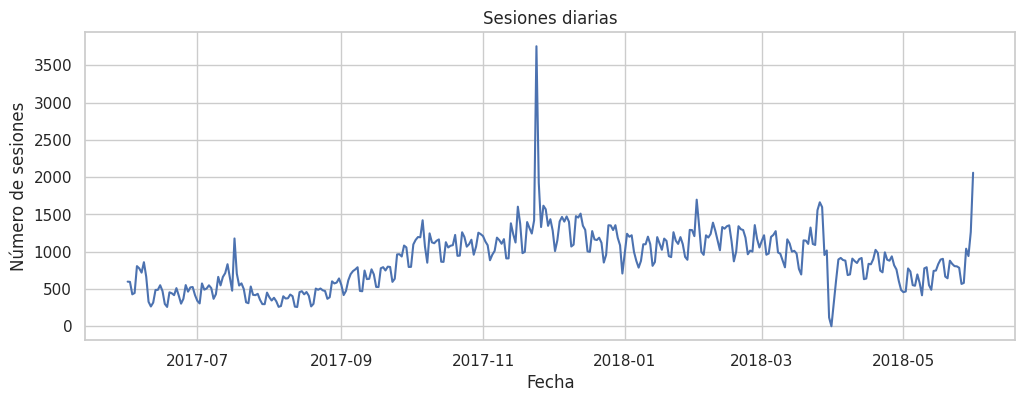

In [4]:
# Cada fila de visits es una sesión: simplemente contamos registros diarios
sessions_per_day = visits.groupby(visits['start_ts'].dt.date) \
                         .size() \
                         .rename('sessions')

# Visualización
plt.figure(figsize=(12, 4))
sessions_per_day.plot(title='Sesiones diarias')
plt.xlabel('Fecha')
plt.ylabel('Número de sesiones')
plt.show()


### 2.1.3 Duración por sesión
Este histograma revela si las sesiones tienden a ser cortas (p. ej., navegación rápida) o largas (p. ej., exploración detallada), y permite detectar outliers.

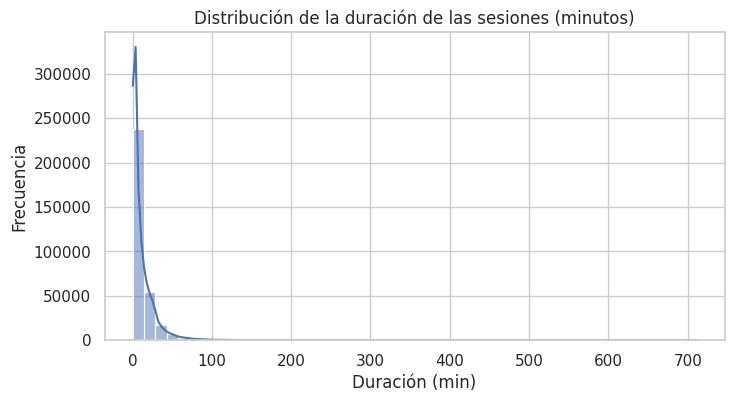

In [5]:
# Ya calculamos la duración en minutos en la limpieza previa (session_duration_min)
# Distribución de la duración de sesiones
plt.figure(figsize=(8, 4))
sns.histplot(visits['session_duration_min'], bins=50, kde=True)
plt.title('Distribución de la duración de las sesiones (minutos)')
plt.xlabel('Duración (min)')
plt.ylabel('Frecuencia')
plt.show()


### 2.1.4 Frecuencia de retorno de usuarios
Al analizar los días transcurridos entre sesiones, podemos definir ventanas de retención (1d, 7d, 30d) y cuantificar la lealtad y el “stickiness” del servicio.

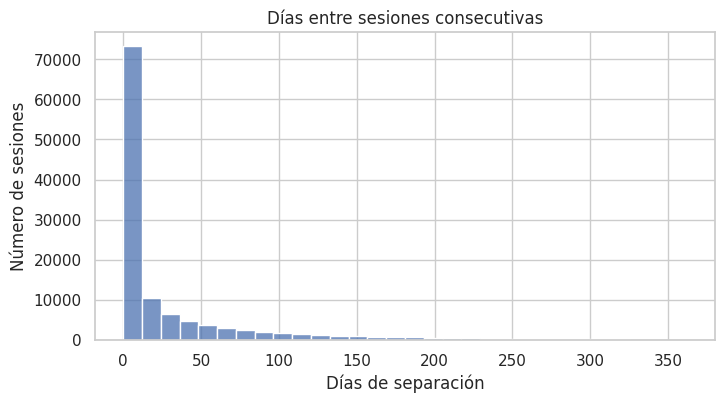

In [6]:
# Ordenamos y calculamos diferencia en días entre sesiones consecutivas por usuario
visits = visits.sort_values(['uid', 'start_ts'])
visits['prev_start'] = visits.groupby('uid')['start_ts'].shift()
visits['days_since_prev'] = (visits['start_ts'] - visits['prev_start']).dt.days

# Distribución de los intervalos de retorno
plt.figure(figsize=(8, 4))
sns.histplot(visits['days_since_prev'].dropna(), bins=30)
plt.title('Días entre sesiones consecutivas')
plt.xlabel('Días de separación')
plt.ylabel('Número de sesiones')
plt.show()

## 2.2 Ventas
### 2.2.1 Cuándo empieza la gente a comprar (Conversion Lag)
Identificamos el número de días que tardan los usuarios entre su primera visita y su primera compra. Esto nos permite comparar la velocidad de conversión por cohorte o por canal.

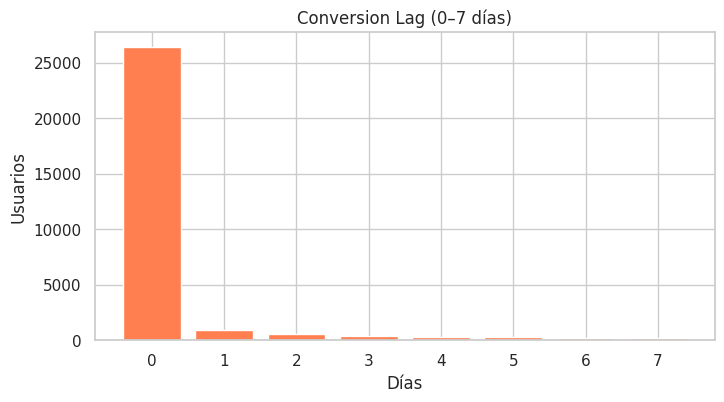

In [7]:
# 1. Fecha de primera visita
first_visit = (
    visits
    .groupby('uid')['start_ts']
    .min()
    .reset_index()
    .rename(columns={'start_ts': 'first_visit_ts'})
)

# 2. Fecha de primera compra
first_order = (
    orders
    .groupby('uid')['buy_ts']
    .min()
    .reset_index()
    .rename(columns={'buy_ts': 'first_order_ts'})
)

# 3. Merge y cálculo de días de conversión
# Conteo por día de conversión
conv = first_visit.merge(first_order, on='uid', how='inner')
conv['conversion_days'] = (
    conv['first_order_ts'] - conv['first_visit_ts']
).dt.days
conv_counts = conv['conversion_days'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(8,4))
subset = conv_counts.loc[0:7]
plt.bar(subset.index, subset.values, color='coral')
plt.title('Conversion Lag (0–7 días)')
plt.xlabel('Días')
plt.ylabel('Usuarios')
plt.show()


### 2.2.2 Número de pedidos por período
Contamos cuántos pedidos se realizan por día y por semana para ver la evolución del volumen de ventas.

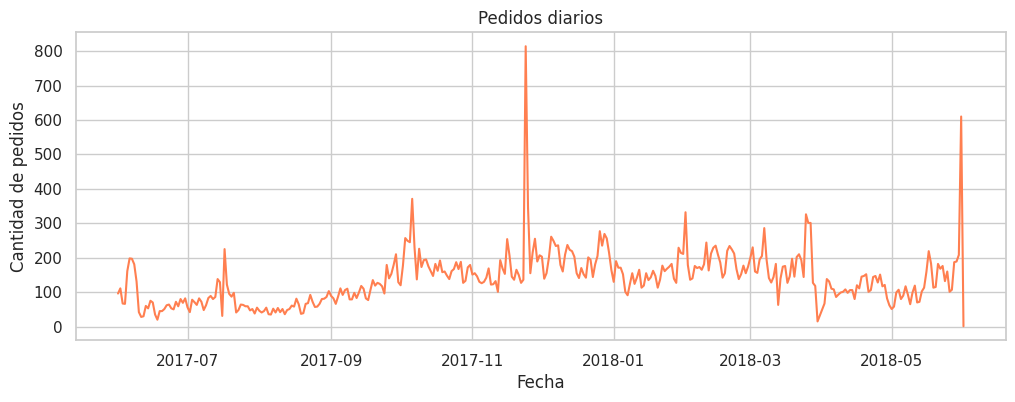

In [8]:
# Pedidos diarios
orders_daily = (
    orders
    .groupby(orders['buy_ts'].dt.date)
    .size()
    .rename('daily_orders')
)

# Pedidos semanales (ISO week)
orders_weekly = (
    orders
    .groupby(orders['buy_ts'].dt.to_period('W'))
    .size()
    .rename('weekly_orders')
)

# Plot de pedidos diarios
plt.figure(figsize=(12,4))
orders_daily.plot(color='coral')
plt.title('Pedidos diarios')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de pedidos')
plt.show()


### 2.2.3 Tamaño promedio de compra
Calculamos el ticket promedio y revisamos su distribución para entender el comportamiento de gasto.

Valor promedio por pedido: $5.00
Mediana del valor de pedido: $2.50


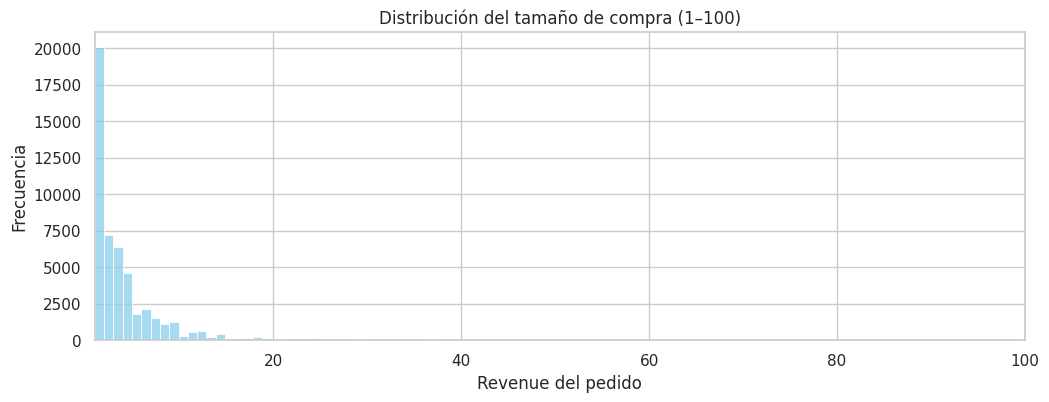

In [9]:
# Ticket promedio
avg_order_value = orders['revenue'].mean()
median_order_value = orders['revenue'].median()

print(f"Valor promedio por pedido: ${avg_order_value:,.2f}")
print(f"Mediana del valor de pedido: ${median_order_value:,.2f}")

# Filtrar/clipear revenue entre 1 y 1000
rev_1_100 = orders['revenue'].clip(lower=1, upper=100)

plt.figure(figsize=(12, 4))
sns.histplot(
    rev_1_100,
    bins=100,
    color='skyblue'
)
plt.title('Distribución del tamaño de compra (1–100)')
plt.xlabel('Revenue del pedido')
plt.ylabel('Frecuencia')
plt.xlim(1, 100)
plt.show()

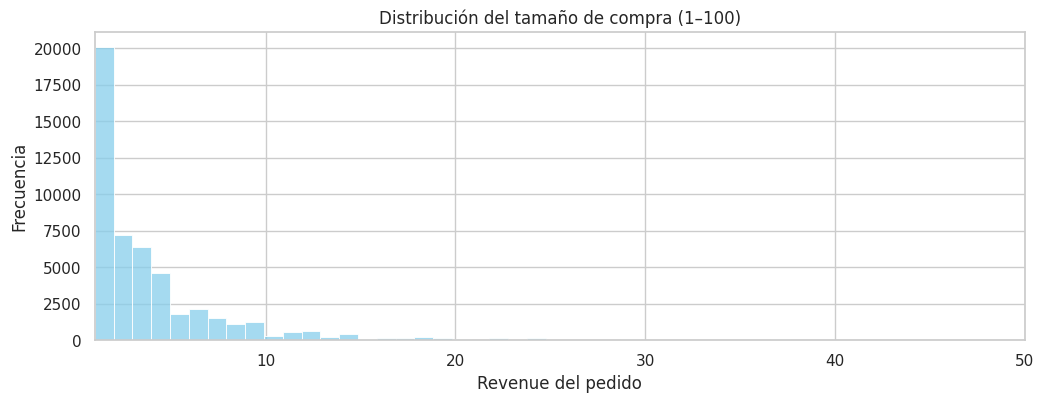

In [10]:
# Filtrar/clipear revenue entre 1 y 100
rev_1_50 = orders['revenue'].clip(lower=1, upper=50)

plt.figure(figsize=(12, 4))
sns.histplot(
    rev_1_100,
    bins=100,
    color='skyblue'
)
plt.title('Distribución del tamaño de compra (1–100)')
plt.xlabel('Revenue del pedido')
plt.ylabel('Frecuencia')
plt.xlim(1, 50)
plt.show()

### 2.2.4 Valor de vida del cliente (LTV)
En este proceso vamos a obtener el valor de vida (LTV) de cada usuario a partir de su historial de pedidos. El LTV representa la suma total de ingresos que un cliente ha generado desde su primera compra hasta la última.

In [11]:
# Tomando en consideración las columnas de uid y revenue, hacemos el cálculo
ltv_per_user = (
    orders
    .groupby('uid')['revenue']
    .sum()
    .reset_index(name='ltv')
)

print(ltv_per_user.head())

                uid    ltv
0   313578113262317   0.55
1  1575281904278712   3.05
2  2429014661409475  73.33
3  2464366381792757   2.44
4  2551852515556206  10.99


## 2.3 Marketing
### 2.3.1 Total por fuente de adquisición a lo largo del tiempo
En esta sección calculamos cómo evoluciona el gasto de marketing en cada canal a lo largo del tiempo.

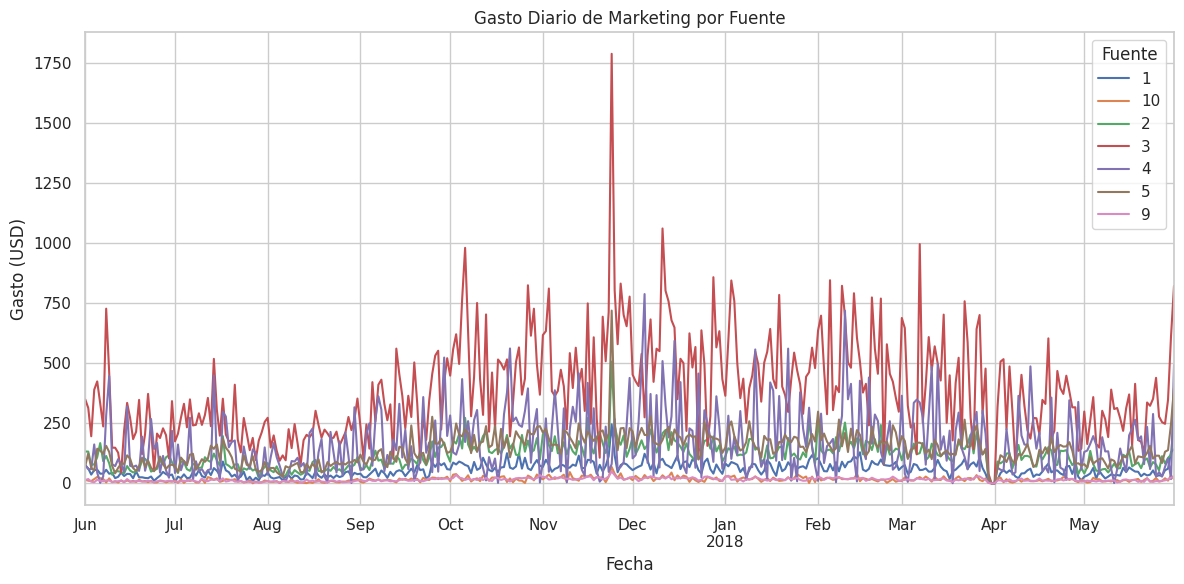

In [12]:
# 1. Convertir date a datetime y ponerlo como índice
costs['date'] = pd.to_datetime(costs['date'])
costs = costs.set_index('date')

# 2. Agregar gasto diario por fuente
daily = (
    costs
    .groupby([pd.Grouper(freq='D'), 'source_id'])['cost']
    .sum()
    .unstack(fill_value=0)
)

# 3. Graficar evolución
daily.plot(figsize=(12,6))
plt.title('Gasto Diario de Marketing por Fuente')
plt.xlabel('Fecha')
plt.ylabel('Gasto (USD)')
plt.legend(title='Fuente')
plt.tight_layout()
plt.show()


### 2.3.2 Costos de adquisición de fuentes
En la siguiente sección calcularemos el CAC usando los datos desde los tres datasets

In [13]:
# 1. Primera fuente de cada usuario
first_source = (
    visits
    .sort_values('start_ts')
    .groupby('uid', as_index=False)['source_id']
    .first()
)

# 2. Usuarios que compraron (clientes)
acquired = orders[['uid']].drop_duplicates()
acquired = acquired.merge(first_source, on='uid', how='left')

# 3. Número de clientes por fuente
clients_per_source = (
    acquired
    .groupby('source_id')['uid']
    .nunique()
    .reset_index(name='customers')
)

# 4. Gasto total por fuente
costs_per_source = (
    costs
    .groupby('source_id', as_index=False)['cost']
    .sum()
    .rename(columns={'cost': 'total_cost'})
)

# 5. Calcular CAC
cac = costs_per_source.merge(clients_per_source,
                             on='source_id',
                             how='left')
cac['CAC'] = cac['total_cost'] / cac['customers']

cac.sort_values('CAC')


,source_id,total_cost,customers,CAC
1,10,5822.49,1304,4.465100
6,9,5517.49,1087,5.075888
4,4,61073.60,10113,6.039118
0,1,20833.27,2961,7.035890
5,5,51757.10,6847,7.559092
2,2,42806.04,3512,12.188508
3,3,141321.63,10242,13.798245


### 2.3.3 Rentabilidad de las inversiones (ROMI)

In [18]:
# 1. Preparar datos y calcular ingresos por fuente

# Agrupar ingresos por usuario
user_revenue = (
    orders
    .groupby('uid', as_index=False)['revenue']
    .sum()
    .rename(columns={'revenue': 'total_revenue'})
)

# Obtener la primera fuente de cada usuario
first_source = (
    visits
    .sort_values('start_ts')
    .groupby('uid', as_index=False)['source_id']
    .first()
)

# Unir para asignar ingresos a cada fuente
revenue_per_source = (
    first_source
    .merge(user_revenue, on='uid', how='left')
    .groupby('source_id', as_index=False)['total_revenue']
    .sum()
)

# 2. Calcular costos por fuente

costs_per_source = (
    costs
    .groupby('source_id', as_index=False)['cost']
    .sum()
    .rename(columns={'cost': 'total_cost'})
)

# 3. Unir y calcular ROMI

romi = (
    revenue_per_source
    .merge(costs_per_source, on='source_id')
)
romi['ROMI'] = (
    romi['total_revenue'] - romi['total_cost']
) / romi['total_cost']

romi.sort_values('ROMI', ascending=False)



,source_id,total_revenue,total_cost,ROMI
0,1,30537.37,20833.27,0.465798
2,2,47265.19,42806.04,0.104171
6,9,5746.85,5517.49,0.041570
5,5,53352.23,51757.10,0.030820
4,4,55601.15,61073.60,-0.089604
1,10,4611.73,5822.49,-0.207945
3,3,53061.62,141321.63,-0.624533


# Paso 3. Conclusiones y recomendaciones de inversión
## Métricas clave y criterios de selección
Para orientar la asignación de presupuesto, combinamos dos indicadores fundamentales:

* CAC (Costo de Adquisición de Cliente): refleja cuánto cuesta adquirir un nuevo cliente en cada canal.

* ROMI (Rentabilidad sobre la Inversión de Marketing): mide la ganancia neta por cada dólar invertido.

Criterios de filtro:

1. Priorizar canales con CAC < 8 USD para maximizar el número de clientes.

2. Seleccionar solo fuentes con ROMI > 0 para asegurar retorno positivo.

3. Destinar partidas piloto a canales con ROMI marginal pero prometedor, antes de escalar.


Teniendo en cuenta lo que se demuestra con el enfoque dual al CAC y el ROMI calculado en pasos previos llegamos a las:
### Conclusiones del análisis

1. **Fuente 1** ofrece el ROMI más alto (0.466) con un CAC controlado (7.04 USD); es el pilar del crecimiento rentable.

2. **Fuente 9** combina el CAC más bajo (5.08 USD) y ROMI positivo; ideal para escalar tras optimizar creatividades.

3. **Fuente 5** presenta CAC y ROMI cercanos al umbral; merece pruebas de mensajes y audiencias antes de aumentar inversión.

4. **Fuente 2** tiene ROMI positivo pero CAC elevado; asignar presupuesto limitado para ajustar targeting y reducir coste por cliente.

5. **Fuentes 4, 10 y 3** arrojan ROMI negativo; pausar inversión y reasignar presupuesto a los canales más rentables.

Con esta distribución maximizamos la adquisición eficiente y garantizamos un retorno positivo, reservando espacio para validar y optimizar canales secundarios.